In [1]:
import pandas as pd
from pathlib import Path
%matplotlib inline

## Описательный анализ данных (как минимум 10 разных статистик) - 1 

In [2]:
DATA_HOME = Path(r"data")

In [ ]:
toxic_train_df = pd.read_csv(DATA_HOME.joinpath('jigsaw-toxic-comment-train.csv'))
bias_train_df = pd.read_csv(DATA_HOME.joinpath('jigsaw-unintended-bias-train.csv'))

In [ ]:
import regex as re
from nltk import sent_tokenize, word_tokenize
from string import punctuation
from typing import List
from lazy_property import LazyProperty
import numpy as np

symbol_multiplication_re = re.compile(r'(\w)\1{2,}')
exclamation_multiplication_re = re.compile(r'(!)\1{2,}')
interrogation_multiplication_re = re.compile(r'(\?)\1{2,}')
caps_re = re.compile(r'\b\p{Lu}+\b')
EXCLAMATION_RE = re.compile(r'!+')
INTERROGATION_RE = re.compile(r'\?+')

CONTRACTION_MAP = {
    "'m": "am",
    "'s'": "is",
    "n't": "not",
    "'re'": "are"
}

class Word:
    symbols: str

    def __init__(self, word: str):
        self.symbols = word
        
    def __len__(self):
        return len(self.symbols)
    
    @property
    def has_multiplied_characters(self):
        return bool(symbol_multiplication_re.match(self.symbols))
    
    @property
    def is_a_contraction(self):
        return self.symbols in CONTRACTION_MAP


DICT = {}


class Sentence:
    text: str
    words: List[Word]
    tokens: List[str]

    def __init__(self, text: str):
        self.text = text
        self.words = []
        self.tokens = []
        self.__parse_words()
        self.symbol_count = 0
        self.average_symbol_count = .0
        self.__count_metrics()

    def __parse_words(self):
        for token in word_tokenize(self.text):
            if token not in punctuation:
                self.words.append(Word(token))
            self.tokens.append(token)

    def __len__(self):
        return len(self.words)

    def __iter__(self) -> Word:
        for word in self.words:
            yield word

    def __str__(self):
        return self.text

    def __count_metrics(self):
        for word in self:
            self.symbol_count += len(word)


class Text:
    sentences: List[Sentence]
    text: str
    lang: str

    def __init__(self, text_string: str, lang: str = 'english'):
        self.lang = lang
        self.text = text_string
        self.sentences = []
        self.words = []
        self.__parse()
        self.total_words = 0
        self.total_words_with_multiplied_chars = 0
        self.total_symbols = 0

        self.total_exclamative = 0
        self.total_interrogative = 0

    def __parse(self):
        for sent in sent_tokenize(self.text, self.lang):
            self.sentences.append(Sentence(sent))

    def __len__(self):
        return len(self.sentences)

    def __iter__(self) -> Sentence:
        for sent in self.sentences:
            yield sent

    @LazyProperty
    def word_count(self):
        return sum(len(sent) for sent in self)
    
    @property
    def prolonged_words_count(self):
        return self.total_words_with_multiplied_chars


    def count_metrics(self):
        if self.word_count:
            for sent in filter(lambda s: len(s), self):
                self.total_symbols += sent.symbol_count
                for word in sent:
                    self.words.append(word)
                    if word.has_multiplied_characters:
                        self.total_words_with_multiplied_chars += 1


    @property
    def sent_in_words_average_len(self):
        if len(self):
            return self.word_count / len(self)
        return np.nan


    @property
    def sent_sym_average_len(self):
        if len(self):
            return self.total_symbols / len(self)
        return np.nan

    @property
    def word_in_sym_average_len(self):
        if self.word_count:
            return self.total_symbols / self.word_count
        return np.nan


    @property
    def interrogative_sent_word_ratio(self):
        if len(self):
            return len(INTERROGATION_RE.findall(self.text)) / len(self)
        return np.nan

    @property
    def exclamative_sent_word_ratio(self):
        if len(self.text):
            return len(EXCLAMATION_RE.findall(self.text)) / len(self)
        return np.nan
    
    @property
    def total_multiplied_exclamations(self):
        if len(self.text):
            return len(exclamation_multiplication_re.findall(self.text))
        return np.nan
    
    @property
    def total_multiplied_interrogations(self):
        return len(interrogation_multiplication_re.findall(self.text))

In [ ]:
from tqdm.notebook import trange, tqdm

In [ ]:
for idx in tqdm(train_df.index[train_df.index >= 178686]):
    text = Text(train_df.loc[idx, "comment_text"])
    text.count_metrics()
    train_df.loc[idx, "word_count"] = text.word_count
    train_df.loc[idx, "sent_count"] = len(text)
    train_df.loc[idx, "sym_count"] = text.total_symbols
    train_df.loc[idx, "total_multiplied_interrogations"] = text.total_multiplied_interrogations
    train_df.loc[idx, "total_multiplied_exclamations"] = text.total_multiplied_exclamations
    train_df.loc[idx, "exclamative_sent_word_ratio"] = text.exclamative_sent_word_ratio
    train_df.loc[idx, "interrogative_sent_word_ratio"] = text.interrogative_sent_word_ratio
    train_df.loc[idx, "word_in_sym_average_len"] = text.word_in_sym_average_len
    train_df.loc[idx, "sent_sym_average_len"] = text.sent_sym_average_len
    train_df.loc[idx, "sent_in_words_average_len"] = text.sent_in_words_average_len
    train_df.loc[idx, "prolonged_words_count"] = text.prolonged_words_count

In [ ]:
for idx in tqdm(val_df.index):
    text = Text(val_df.loc[idx, "comment_text"])
    text.count_metrics()
    val_df.loc[idx, "word_count"] = text.word_count
    val_df.loc[idx, "sent_count"] = len(text)
    val_df.loc[idx, "sym_count"] = text.total_symbols
    val_df.loc[idx, "total_multiplied_interrogations"] = text.total_multiplied_interrogations
    val_df.loc[idx, "total_multiplied_exclamations"] = text.total_multiplied_exclamations
    val_df.loc[idx, "exclamative_sent_word_ratio"] = text.exclamative_sent_word_ratio
    val_df.loc[idx, "interrogative_sent_word_ratio"] = text.interrogative_sent_word_ratio
    val_df.loc[idx, "word_in_sym_average_len"] = text.word_in_sym_average_len
    val_df.loc[idx, "sent_sym_average_len"] = text.sent_sym_average_len
    val_df.loc[idx, "sent_in_words_average_len"] = text.sent_in_words_average_len
    val_df.loc[idx, "prolonged_words_count"] = text.prolonged_words_count

In [ ]:
val_df

,comment_text,lang,toxic,word_count,sent_count,sym_count,total_multiplied_interrogations,total_multiplied_exclamations,exclamative_sent_word_ratio,interrogative_sent_word_ratio,word_in_sym_average_len,sent_sym_average_len,sent_in_words_average_len,prolonged_words_count
id,,,,,,,,,,,,,,
0,Este usuario ni siquiera llega al rango de ...,es,0,40.0,4.0,190.0,0.0,0.0,0.000000,0.000000,4.750000,47.5,10.000000,0.0
1,Il testo di questa voce pare esser scopiazzato...,it,0,20.0,2.0,107.0,0.0,0.0,0.000000,0.000000,5.350000,53.5,10.000000,0.0
2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,27.0,4.0,134.0,0.0,0.0,0.000000,0.000000,4.962963,33.5,6.750000,0.0
3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,49.0,1.0,334.0,0.0,0.0,0.000000,0.000000,6.816327,334.0,49.000000,0.0
4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,55.0,6.0,351.0,0.0,0.0,0.000000,0.166667,6.381818,58.5,9.166667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,Il fatto è che la pagina dei personaggi minor...,it,0,36.0,2.0,189.0,0.0,0.0,0.000000,0.000000,5.250000,94.5,18.000000,0.0
7996,El imbesil ete dela luna no se entera ni ostia...,es,1,31.0,3.0,144.0,0.0,1.0,0.666667,0.000000,4.645161,48.0,10.333333,0.0
7997,olum sız manyakmısınz siz adam sıze sanal yıld...,tr,1,33.0,1.0,185.0,0.0,0.0,0.000000,0.000000,5.606061,185.0,33.000000,0.0


In [ ]:
train_df.to_csv(DATA_HOME.joinpath("train_with_metrics.csv"))

In [ ]:
train_df.toxic.value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

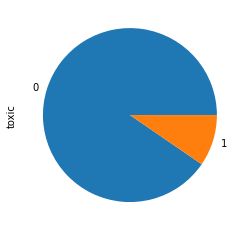

In [ ]:
train_df.toxic.value_counts().plot(kind='pie')

Судя по распределению классов, датасет не сбалансирован, будем использовать кроссвалидацию со стратификацией

In [ ]:
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,total_multiplied_exclamations,word_count,sent_count,total_multiplied_interrogations,exclamative_sent_word_ratio,interrogative_sent_word_ratio,word_in_sym_average_len,sent_sym_average_len,sent_in_words_average_len,prolonged_words_count,sym_count
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223539.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,0.038139,69.924218,4.320485,0.008361,0.069219,0.102096,4.570586,73.113745,16.175805,0.022228,313.816179
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,1.465871,104.554245,6.937251,0.154576,1.431872,0.286538,5.724356,137.485942,29.087106,0.970425,477.655166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,2.000000,0.000000,0.000000,0.000000,4.000000,37.166667,8.500000,0.000000,74.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,3.000000,0.000000,0.000000,0.000000,4.383333,58.500000,13.333333,0.000000,162.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.000000,5.000000,0.000000,0.000000,0.000000,4.774194,86.000000,19.125000,0.000000,346.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,357.000000,2142.000000,683.000000,46.000000,383.000000,77.000000,1241.000000,4992.000000,2142.000000,385.000000,4992.000000


In [ ]:
test_df = pd.read_csv(DATA_HOME.joinpath('test.csv'), index_col=0)
val_df = pd.read_csv(DATA_HOME.joinpath('validation.csv'), index_col=0)

In [ ]:
val_df.groupby('lang').agg({'toxic' : ['sum', 'count']})

toxic      
       sum count
lang            
es     422  2500
it     488  2500
tr     320  3000

То же самое можно сказать и про валидационную выборку, однако заметно, что по языкам соотношение таксичных и нетоксичных коментариев прибизительно одинаково, что есть хорошо, так как корреляция языка и токсичности комментариев должна быть сведена к минимуму.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ed2c3bb38>,
      dtype=object)

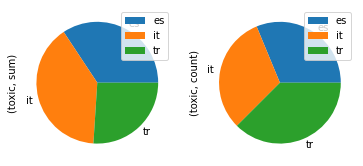

In [ ]:
val_df.groupby('lang').agg({'toxic' : ['sum', 'count']}).plot(kind='pie', subplots=True)

## Бейзлайн модель, которая работает на отложенной выборке (train_test_split) и validation.csv (различие в точности может быть большим, но главное попробовать любыми способами его уменьшить и зафиксировать эксперименты) - 3 балла

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [5]:
selected_df = train_df[(~train_df.word_count.isna()) & (train_df.word_count > 0)]

In [6]:
selected_df.toxic.value_counts()

0    202155
1     21384
Name: toxic, dtype: int64

In [7]:
fields = ['total_multiplied_exclamations',
     'word_count',
     'sent_count',
     'total_multiplied_interrogations',
     'exclamative_sent_word_ratio',
     'interrogative_sent_word_ratio',
     'word_in_sym_average_len',
     'sent_sym_average_len',
     'sent_in_words_average_len',
     'prolonged_words_count',
     'sym_count']

In [7]:
y = selected_df.toxic

In [8]:
vectorizer = TfidfVectorizer(lowercase=False, analyzer='char')

In [9]:
X = vectorizer.fit_transform(selected_df.comment_text)

In [14]:
skf = StratifiedKFold(n_splits=5, random_state=42)

for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"FOLD {idx}")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2})
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print(classification_report(y_test, predicted))
    print(roc_auc_score(y_test, predicted))

/Users/grigoriyarshinov/anaconda3/envs/lab_8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


FOLD 0
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     40431
           1       0.31      0.36      0.33      4277

    accuracy                           0.86     44708
   macro avg       0.62      0.64      0.63     44708
weighted avg       0.87      0.86      0.87     44708

0.6368211894901179
FOLD 1
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     40431
           1       0.31      0.35      0.33      4277

    accuracy                           0.86     44708
   macro avg       0.62      0.64      0.63     44708
weighted avg       0.87      0.86      0.87     44708

0.6356703098812192
FOLD 2
              precision    recall  f1-score   support

           0       0.93      0.92      0.92     40431
           1       0.31      0.36      0.33      4277

    accuracy                           0.86     44708
   macro avg       0.62      0.64      0.63     44708
weighted avg   

## Тест на валидационных данных

In [11]:
predicted = model.predict(vectorizer.transform(val_df.comment_text))
print(classification_report(val_df.toxic, predicted))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      6770
           1       0.18      0.16      0.17      1230

    accuracy                           0.76      8000
   macro avg       0.51      0.51      0.51      8000
weighted avg       0.75      0.76      0.75      8000



In [13]:
roc_auc_score(val_df.toxic, predicted)

0.51231821402409

## Использование предобучнной модели из huggingface для обучения классификатора с оценкой на validation.csv - 3 балла

In [4]:
import pandas as pd

In [3]:
train_df = pd.read_csv(DATA_HOME.joinpath('train_with_metrics.csv'), index_col=0)
val_df = pd.read_csv(DATA_HOME.joinpath('val_with_metrics.csv'), index_col=0)

In [11]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-cased'

In [12]:
from transformers import BertTokenizer
import torch

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
from torch.utils.data import Dataset

class CommentDataset(Dataset):

    def __init__(self, comments, targets, tokenizer, max_len):
        self.comments = comments
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.comments)
  
    def __getitem__(self, item):
        comment = str(self.comments[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          comment,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'comment_text': comment,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [15]:
RANDOM_SEED = 42

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_df.toxic.value_counts()

0    202165
1     21384
Name: toxic, dtype: int64

In [18]:
df_train, df_test = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(val_df, test_size=0.5, random_state=RANDOM_SEED)

In [19]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = CommentDataset(
        comments=df.comment_text.to_numpy(),
        targets=df.toxic.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

In [20]:
MAX_LEN = int(train_df.word_count.quantile(0.85))

In [34]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['comment_text', 'input_ids', 'attention_mask', 'targets'])

In [23]:
from transformers import BertModel

In [36]:
from torch import nn

class ToxicityClassifier(nn.Module):

    def __init__(self, n_classes):
        super(ToxicityClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [38]:
model = ToxicityClassifier(2)
model = model.to(device)

In [27]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [39]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [29]:
from tqdm.notebook import tqdm

In [40]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [47]:
import numpy as np

def eval_model(model, data_loader, loss_fn=None, device=None, n_examples=None):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            if loss_fn:
                loss = loss_fn(outputs, targets)
                losses.append(loss.item())
            else:
                losses = [0]

            correct_predictions += torch.sum(preds == targets)

    return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
from collections import defaultdict

In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

### Модель обучалась в течение одной эпохи

In [48]:
val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    device=device, 
    n_examples=len(df_val)
)

### Качество 

In [49]:
val_acc

tensor(0.8605, device='cuda:0', dtype=torch.float64)

## Поиск признаков, которые могут обобщаться на многоязычные данные (минимум 10 признаков рассмотрено,, обучать можно любую модель, оценивать нужно на validation.csv)  - 3 балла

In [15]:
fields = ['total_multiplied_exclamations',
     'word_count',
     'sent_count',
     'total_multiplied_interrogations',
     'exclamative_sent_word_ratio',
     'interrogative_sent_word_ratio',
     'word_in_sym_average_len',
     'sent_sym_average_len',
     'sent_in_words_average_len',
     'prolonged_words_count',
     'sym_count']

In [16]:
y = selected_df.toxic
X = selected_df[fields]

In [19]:
skf = StratifiedKFold(n_splits=5, random_state=42)

for idx, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"FOLD {idx}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = DecisionTreeClassifier(class_weight={0: 0.8, 1: 0.2})
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print(classification_report(y_test, predicted))
    print(roc_auc_score(y_test, predicted))

/Users/grigoriyarshinov/anaconda3/envs/lab_8/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


FOLD 0
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     40431
           1       0.23      0.11      0.15      4277

    accuracy                           0.88     44708
   macro avg       0.57      0.53      0.54     44708
weighted avg       0.85      0.88      0.86     44708

0.5348425195951083
FOLD 1
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     40431
           1       0.23      0.10      0.14      4277

    accuracy                           0.88     44708
   macro avg       0.57      0.53      0.54     44708
weighted avg       0.84      0.88      0.86     44708

0.5319537258427629
FOLD 2
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     40431
           1       0.22      0.11      0.14      4277

    accuracy                           0.88     44708
   macro avg       0.57      0.53      0.54     44708
weighted avg   

## Тест на валидационных данных

In [20]:
predicted = model.predict(val_df[fields])
print(classification_report(val_df.toxic, predicted))

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      6770
           1       0.23      0.10      0.14      1230

    accuracy                           0.81      8000
   macro avg       0.54      0.52      0.52      8000
weighted avg       0.76      0.81      0.78      8000



In [27]:
sorted(fields, key=lambda x: model.feature_importances_[fields.index(x)], reverse=True)

['word_in_sym_average_len',
 'sent_sym_average_len',
 'sym_count',
 'sent_in_words_average_len',
 'word_count',
 'interrogative_sent_word_ratio',
 'exclamative_sent_word_ratio',
 'sent_count',
 'total_multiplied_exclamations',
 'prolonged_words_count',
 'total_multiplied_interrogations']

Можно заметить, что средняя длина слова в символах по тексту значительно влияет на качество классификации по токсичности. Следом идет средняя длина предложения в символах и количество символов. Такие метрики как количество повторенных знаков припенания типа !!!! или ???? мало влияют на токсичность, вместе с повторением букв в словах и количеством вопросительных предложений.